#**ResNet Training (CIFAR - 10)**

###**1. Import Library & Define Resnet model**

In [ ]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import torchvision
import torchvision.transforms as transforms


class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
        
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
        
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x
    

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x
    
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

###**2. Download CIFAR-10**

In [ ]:
#Download CIFAR10 DATASET

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), 

    transforms.ToTensor(), normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(), normalize
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


###**3. CUDA setting & Define Train,Test function**

In [ ]:
#gpu setting & define Training function

device = 'cuda'

net = resnet34(3,10)           #resnet34 선언
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'resnet34_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)
    total_accuracy = 100. * correct / total;

    return total_accuracy , train_loss


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)
    total_accuracy = 100. * correct / total;
    test_loss = loss / total

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    return total_accuracy , test_loss

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

###**4. Run Training & Save log**

In [ ]:
# for epoch in range(0, 200):
log_train_total_accuracy =[]
log_train_total_loss = []
log_test_total_accuracy =[]
log_test_total_loss =[]


for epoch in range(0, 60):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)


[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.0390625
Current benign train loss: 2.905611991882324

Current batch: 100
Current benign train accuracy: 0.125
Current benign train loss: 2.6095638275146484

Current batch: 200
Current benign train accuracy: 0.1640625
Current benign train loss: 2.231346845626831

Current batch: 300
Current benign train accuracy: 0.1953125
Current benign train loss: 2.0603489875793457

Total benign train accuarcy: 16.958
Total benign train loss: 1145.376464009285

[ Test epoch: 0 ]

Test accuarcy: 25.63
Test average loss: 0.019993010103702545
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.21875
Current benign train loss: 1.9916119575500488

Current batch: 100
Current benign train accuracy: 0.3828125
Current benign train loss: 1.6311910152435303

Current batch: 200
Current benign train accuracy: 0.359375
Current benign train loss: 1.764607548713684

Current batch: 300
Current benign train accuracy: 

In [ ]:
file_name = "/content/checkpoint/resnet34_cifar10.pt"
device = 'cuda'

net = resnet34(3,10)
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

file_name = 'resnet34_cifar10.pt'

for epoch in range(0, 40):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)


[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.859375
Current benign train loss: 0.514398992061615

Current batch: 100
Current benign train accuracy: 0.796875
Current benign train loss: 0.5918214321136475

Current batch: 200
Current benign train accuracy: 0.8046875
Current benign train loss: 0.5039066076278687

Current batch: 300
Current benign train accuracy: 0.8515625
Current benign train loss: 0.4882427453994751

Total benign train accuarcy: 83.144
Total benign train loss: 194.39228546619415

[ Test epoch: 0 ]

Test accuarcy: 81.17
Test average loss: 0.0056623499274253844
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.8125
Current benign train loss: 0.5375174283981323

Current batch: 100
Current benign train accuracy: 0.84375
Current benign train loss: 0.4512741267681122

Current batch: 200
Current benign train accuracy: 0.796875
Current benign train loss: 0.6564188599586487

Current batch: 300
Current benign train accurac

###**5. Plotting Train Accuracy & Loss**

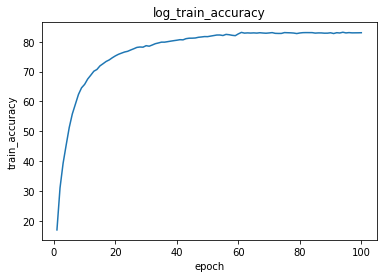

In [ ]:
epoch =[]

for i , loss in enumerate(log_test_total_loss):
  epoch.append(i+1)

import matplotlib.pyplot as plt

plt.title('log_train_accuracy')
plt.plot(epoch , log_train_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('train_accuracy')
plt.show()  

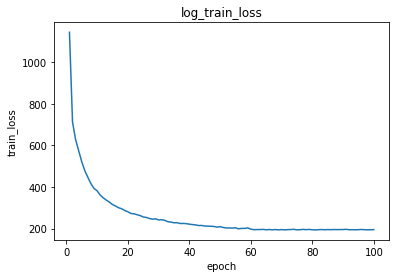

In [ ]:
import matplotlib.pyplot as plt

plt.title('log_train_loss')
plt.plot(epoch , log_train_total_loss)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.show()

###**6. Plotting Test Accuracy & Loss**

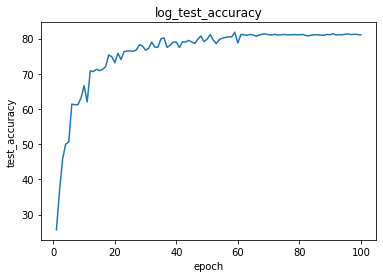

In [ ]:
import matplotlib.pyplot as plt

plt.title('log_test_accuracy')
plt.plot(epoch , log_test_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('test_accuracy')
plt.show()

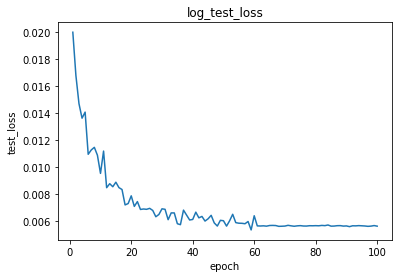

In [ ]:
import matplotlib.pyplot as plt

plt.title('log_test_loss')
plt.plot(epoch , log_test_total_loss)
plt.xlabel('epoch')
plt.ylabel('test_loss')
plt.show()

###**7. Print Result**

In [ ]:
print(log_train_total_accuracy)
print(log_train_total_loss) 
print(log_test_total_accuracy)
print(log_test_total_loss)

[16.958, 31.036, 39.29, 45.398, 51.294, 55.828, 59.092, 62.362, 64.574, 65.73, 67.526, 68.806, 70.138, 70.722, 71.932, 72.656, 73.408, 73.926, 74.646, 75.278, 75.806, 76.202, 76.578, 76.812, 77.262, 77.668, 78.118, 78.252, 78.198, 78.694, 78.524, 78.924, 79.364, 79.61, 79.884, 79.876, 80.044, 80.216, 80.38, 80.526, 80.704, 80.652, 81.048, 81.202, 81.214, 81.274, 81.506, 81.616, 81.748, 81.726, 81.912, 82.088, 82.27, 82.276, 82.104, 82.482, 82.368, 82.174, 82.054, 82.656, 83.144, 82.906, 82.982, 82.928, 82.982, 82.914, 83.03, 82.94, 82.872, 82.962, 83.072, 82.834, 82.8, 82.804, 83.082, 83.038, 83.004, 82.932, 82.762, 82.954, 83.06, 83.08, 83.072, 83.072, 82.91, 82.974, 82.972, 82.886, 82.894, 83.02, 82.772, 83.046, 82.956, 83.2, 82.974, 83.076, 82.994, 83.004, 83.016, 83.04]
[1145.376464009285, 712.8474060297012, 628.2357321977615, 574.447460770607, 521.7628140449524, 478.32270777225494, 446.0342481136322, 415.4375909566879, 393.13697159290314, 381.42300164699554, 361.010634124279, 347.

###**8. Model Summary**

In [ ]:
from torchsummary import summary

model = resnet34(3, 10)
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
        Conv2dAuto-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
        Conv2dAuto-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
 ResNetBasicBlock-10             [-1, 64, 8, 8]               0
       Conv2dAuto-11             [-1, 64, 8, 8]          36,864
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
       Conv2dAuto-14             [-1, 6